In [1]:
import numpy as np
import time
import math
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Class definition

In [6]:
DATASET_PATH= "data_banknote_authentication.txt"
data = pd.read_csv(DATASET_PATH, sep = ',', 
                    header = None, 
                    names = ["variance of WTI", "skewness of WTI", "curtoise of WTI", "entropy", "class"]
                   )
print("Shape of the dataset: {}".format(data.shape))
print(data.isnull().values.any())

Shape of the dataset: (1372, 5)
False


['variance of WTI', 'skewness of WTI']


<function print>

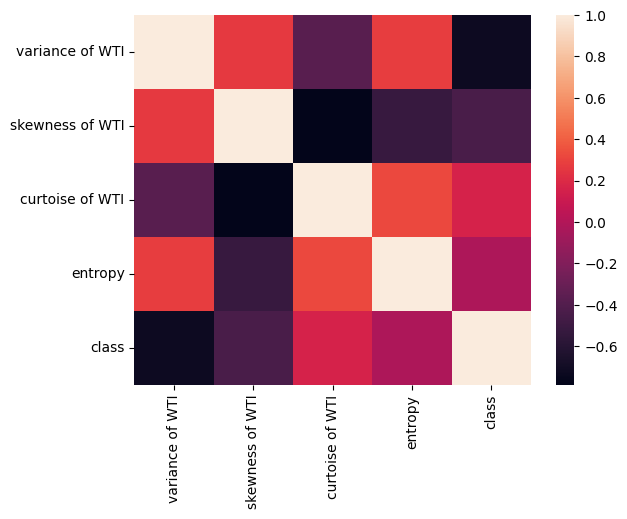

In [4]:

corr_matrix = data.corr()
sns.heatmap(corr_matrix)
corr_matrix = data.corr()["class"].abs().sort_values(ascending=False)
top_features = corr_matrix[1:3].index.tolist()
data = pd.concat([data[top_features], data["class"]], axis=1)
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data['class'] = data['class'].replace({0: float(-1), 1: float(1)})
print(top_features)
data.head()
print

In [5]:
n_labeled= (int(data.shape[0]*1/20))
n_unlabeled= data.shape[0]-n_labeled
labeled0= data[data["class"]== -1][:int(n_labeled/2)]
labeled1= data[data["class"]==1][:int(n_labeled/2)]
labeledf = pd.concat([labeled0, labeled1], axis=0)
unlabeledf= data.drop(labeled1.index)
unlabeledf= unlabeledf.drop(labeled0.index)
labels= np.array(labeledf.iloc[:, -1])
unlabels= np.array(unlabeledf.iloc[:,-1])
labeled=  np.array([[col[0], col[1]] for col in labeledf.iloc[:, 0:2].values])
unlabeled=  np.array([[col[0], col[1]] for col in unlabeledf.iloc[:, 0:2].values])


In [6]:
labeled00=  np.array([[col[0], col[1]] for col in labeled0.iloc[:, 0:2].values])
labeled11=  np.array([[col[0], col[1]] for col in labeled1.iloc[:, 0:2].values])
x1_l=[lab[0] for lab in labeled00]
y1_l=[lab[1] for lab in labeled00]
x2_l=[lab[0] for lab in labeled11]
y2_l=[lab[1] for lab in labeled11]
x1=[unlab[0] for unlab in unlabeled[:int(n_unlabeled/2)]]
y1=[unlab[1] for unlab in unlabeled[:int(n_unlabeled/2)]]
x2=[unlab[0] for unlab in unlabeled[int(n_unlabeled/2):]]
y2=[unlab[1] for unlab in unlabeled[int(n_unlabeled/2):]]
x_unlabeled = np.concatenate((x1, x2))
y_unlabeled = np.concatenate((y1, y2))
x_labeled = np.concatenate((x1_l, x2_l))
y_labeled = np.concatenate((y1_l, y2_l))

CPU times: user 93.2 ms, sys: 1.74 ms, total: 94.9 ms
Wall time: 163 ms


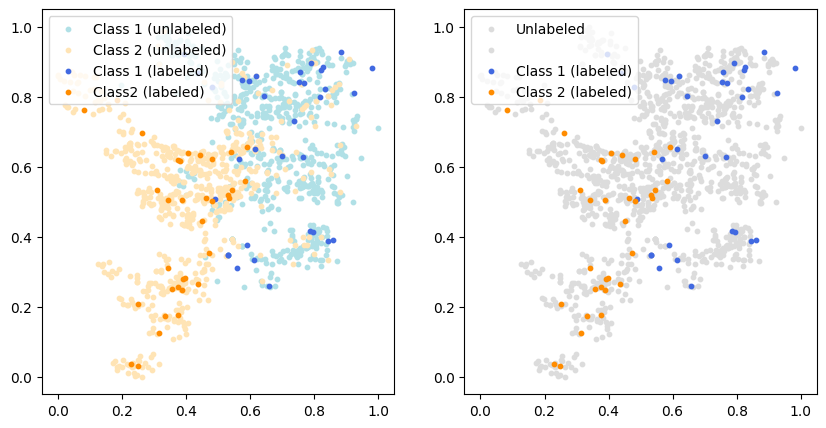

In [7]:

%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.scatter(x1, y1, s=10, c='powderblue')
ax1.scatter(x2, y2, s=10, c='moccasin')
ax1.scatter(x1_l, y1_l, s=10, c='royalblue')
ax1.scatter(x2_l, y2_l, s=10, c='darkorange')
ax1.legend(["Class 1 (unlabeled)", "Class 2 (unlabeled)", "Class 1 (labeled)", "Class2 (labeled)"], loc = "upper left")

    
ax2.scatter(x1, y1, s=10, c='gainsboro')
ax2.scatter(x2, y2, s=10, c='gainsboro')
ax2.scatter(x1_l, y1_l, s=10, c='royalblue')
ax2.scatter(x2_l, y2_l, s=10, c='darkorange')
ax2.legend(["Unlabeled", "" ,"Class 1 (labeled)", "Class 2 (labeled)"], loc = "upper left")


In [8]:
%%time
def similarity (x, y):
  dist = np.linalg.norm(x-y, 2)
  return 1/(0.001+dist)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [9]:
%%time
w_lu = np.zeros((n_labeled, n_unlabeled))
for i in range(n_labeled):
  for j in range(n_unlabeled):
    w_lu[i,j] = similarity(labeled[i], unlabeled[j])

CPU times: user 834 ms, sys: 13.9 ms, total: 848 ms
Wall time: 1.02 s


In [10]:
%%time
w_uu = np.zeros((n_unlabeled, n_unlabeled))
diagonal = []
for i in range(n_unlabeled):
    for j in range(i, n_unlabeled):
        w_uu[i, j] = similarity(unlabeled[i], unlabeled[j])

        if i == j:
            diagonal.append(w_uu[i, i])

w_uu = w_uu + w_uu.T - np.diag(diagonal)

CPU times: user 8.13 s, sys: 134 ms, total: 8.26 s
Wall time: 11.6 s


In [11]:
scaler = MinMaxScaler()
scaler.fit(w_uu)
w_uu = scaler.transform(w_uu)

scaler.fit(w_lu)
w_lu = scaler.transform(w_lu)

In [12]:
%%time
def Hessian2():
  hessian = -2 * w_uu
  diag = [(2 * (np.sum(w_lu[:,j]) + np.sum(w_uu[:,j]))) for j in range(n_unlabeled)]
  np.fill_diagonal(hessian,diag)
  return hessian

h = Hessian2()
eigs=np.linalg.eigvalsh(h)
L = np.amax(eigs)

CPU times: user 624 ms, sys: 159 ms, total: 783 ms
Wall time: 883 ms


In [13]:
Li = np.array([h[i][i] for i in range(len(h))])
probs = Li/ np.sum(Li)

### Formalization of the problem ### 

In [14]:
def gradient(y):
    grad=[]
    for j in range(n_unlabeled):
        p_0, p_1, p_2, p_3 = 0, 0, 0, 0
        p_0 = np.sum(w_lu[:,j]) + np.sum(w_uu[:,j])
        p_1 = p_0*y[j]
        p_2 = np.dot(w_lu[:,j], labels)
        p_3 = np.dot(w_uu[:,j], y)
        result = 2*(p_1 - p_2 - p_3)
        grad.append(result)

    return np.array(grad) 

In [15]:
def vector_gradient(y):
    vector_1,vector_2,vector_3,vector_4 = 0,0,0,0
    vector_1 = np.multiply(np.sum(w_lu, axis = 0), y)
    vector_2 = np.dot(np.float128(w_lu.T), np.float128(labels))
    vector_3 = np.multiply(np.sum(w_uu, axis = 0), y)
    vector_4 = np.dot(w_uu.T, y)

    return 2*(vector_1 - vector_2 + vector_3 - vector_4)

In [16]:
def loss(y):
    start = time.time()
    term_1, term_2 = 0, 0
    for i in range(n_labeled):
      for j in range(n_unlabeled):
        term_1 += w_lu[i,j] * (y[j]-labels[i])**2
    for i in range(n_unlabeled):
      for j in range(n_unlabeled):
        term_2 += w_uu[i,j] * (y[i] - y[j])**2
    end = time.time()
    print(end - start)
    return term_1 + term_2/2

In [17]:
def vector_loss(y):

    # term 1
    loss = 0
    loss += np.dot(np.sum(w_lu, axis = 0), y**2)
    loss += np.dot(np.sum(w_lu, axis = 1), labels**2)
    loss -= 2 * np.dot(np.dot(w_lu, y).T, labels)
    
    # term 2
    loss += 0.5 * np.dot(np.sum(w_uu, axis = 0), y**2)
    loss += 0.5 * np.dot(np.sum(w_uu, axis = 1), y**2)
    loss -= np.dot(np.dot(w_uu, y).T, y)
    
    return loss

In [18]:
def accuracy(y_model): #y_model is the output of one of the models
    y_model_binary = [1 if i >= 0 else -1 for i in y_model]
    return np.sum(np.equal(y_model_binary,unlabels)/ len(unlabels))*100

In [19]:
y_0 = np.random.uniform(-1, 1, n_unlabeled)

## Gradient descent

### Gradient descent with fixed step size

In [20]:
def gradient_fixed(y_0):
  start = time.time()
  y = y_0.copy()
  numiter = 0
  tol = 1e-2
  norm_incr = 1
  normgrad = 1
  maxiter = 25000

  old_loss = vector_loss(y)

  init_time = time.time() * 1000

  ticks_gd = [time.time() * 1000 - init_time] # CPU time
  vec_accuracy_gd = [accuracy(y)] # accuracy
  vec_iter_gd = [0] # number of iterations
  vec_loss_gd = [old_loss] # loss

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gd[0], vec_accuracy_gd[0]))

  while numiter < maxiter and norm_incr > tol: 

    numiter += 1

    d = -vector_gradient(y) 
    normgrad = np.linalg.norm(d, 2)
    y = y + 1/L * d.T

    loss = vector_loss(y) # loss of the precedent iteration
    acc = accuracy(y) # accuracy of the precedent iteration
    
    vec_accuracy_gd.append(acc)
    vec_iter_gd.append(numiter)
    vec_loss_gd.append(loss)

    norm_incr = abs(old_loss - loss) # absolute value between the loss in two consecutive iterations
    old_loss = loss

    print("Iterazione {} -- Loss: {} -- Accuracy: {}%".format(numiter, loss, acc))
    ticks_gd.append(time.time() * 1000 - init_time)
    

  end = time.time()
  print(y)
 
  return y, vec_iter_gd, vec_accuracy_gd, vec_loss_gd, ticks_gd

In [21]:
%%time
### WE CALL THE FUNCTION GRADIENT DESCEND ###

y_GDfixed, vec_iter_gd, vec_accuracy_gd, vec_loss_gd, ticks_gd = gradient_fixed(y_0)
y_GDfixed

Initial loss = 16270.105389802755 -- Initial accuracy = 49.769938650306756
Iterazione 1 -- Loss: 10674.096679934893 -- Accuracy: 63.880368098159515%
Iterazione 2 -- Loss: 9312.361138063767 -- Accuracy: 79.06441717791411%
Iterazione 3 -- Loss: 8832.128478590039 -- Accuracy: 86.65644171779141%
Iterazione 4 -- Loss: 8628.015763350733 -- Accuracy: 90.10736196319019%
Iterazione 5 -- Loss: 8531.104735062887 -- Accuracy: 91.8711656441718%
Iterazione 6 -- Loss: 8481.533009587705 -- Accuracy: 92.10122699386504%
Iterazione 7 -- Loss: 8454.747439638604 -- Accuracy: 92.10122699386504%
Iterazione 8 -- Loss: 8439.639608470117 -- Accuracy: 92.25460122699387%
Iterazione 9 -- Loss: 8430.813501385366 -- Accuracy: 92.25460122699387%
Iterazione 10 -- Loss: 8425.50108712424 -- Accuracy: 92.25460122699387%
Iterazione 11 -- Loss: 8422.219196515896 -- Accuracy: 92.25460122699387%
Iterazione 12 -- Loss: 8420.144021932745 -- Accuracy: 92.25460122699387%
Iterazione 13 -- Loss: 8418.803834285938 -- Accuracy: 92.2

array([ 0.49743343, -0.42454455, -0.41255365, ...,  0.67846712,
        0.60371132,  0.52166047], dtype=float128)

CPU times: user 92.5 ms, sys: 60 µs, total: 92.6 ms
Wall time: 163 ms


Text(0, 0.5, 'Loss')

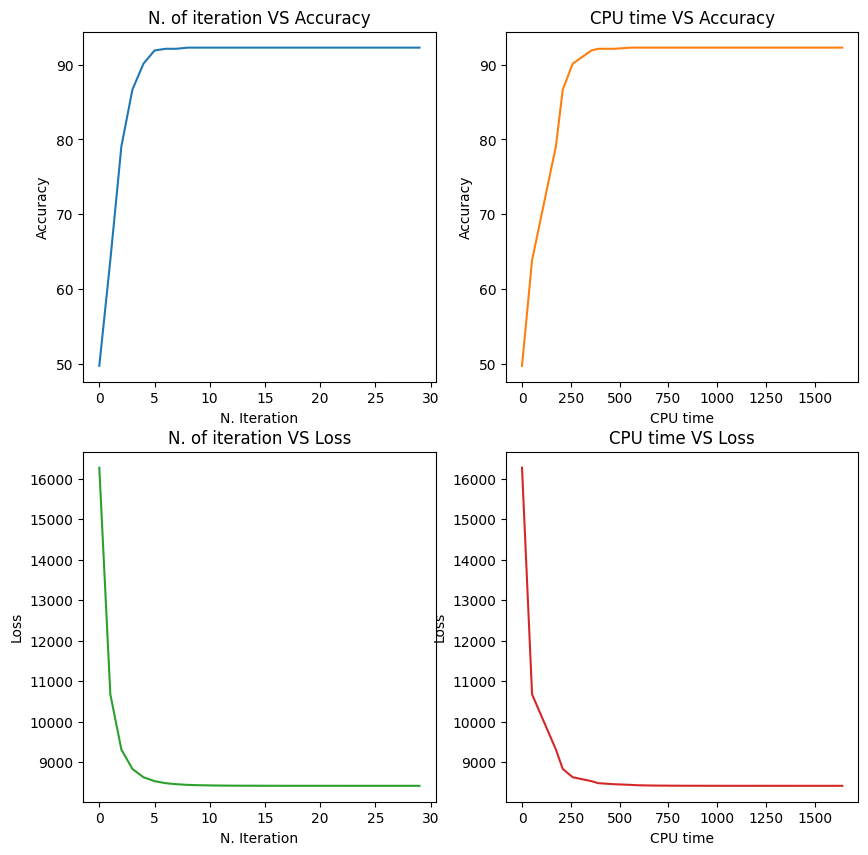

In [22]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_gd,vec_accuracy_gd,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_gd , vec_accuracy_gd, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_gd, vec_loss_gd, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_gd , vec_loss_gd, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')






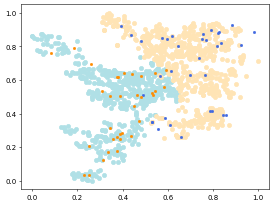

In [23]:

y_GDfixed = [1 if i >= 0 else -1 for i in y_GDfixed]

x1_GD = x_unlabeled[y_GDfixed==np.ones(n_unlabeled)]
y1_GD = y_unlabeled[y_GDfixed==np.ones(n_unlabeled)]
x2_GD = x_unlabeled[y_GDfixed==-np.ones(n_unlabeled)]
y2_GD = y_unlabeled[y_GDfixed==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GD,y1_GD,c='powderblue')
plt.scatter(x2_GD,y2_GD,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gradient descent with Armijo rule

In [24]:
%%time
def Armijo(x, d):
  
  delta = 0.5 #1/2 # tra (0,1)
  gamma = 1e-4 #1e-4 tra (0, 1/2)
  alpha = 1
  step_size = 1
  m = 0

  while vector_loss(x + alpha*d) > (vector_loss(x) + gamma * alpha * np.dot(gradient(x).T, d)):
    alpha = delta**m * step_size
    m += 1

  return alpha

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [25]:
def GS_Armijo(y_0):
  start = time.time()
  y = y_0.copy()
  numiter = 0
  tol = 1e-3
  normgrad = 1
  norm_incr = 1
  maxiter = 25000

  old_loss = vector_loss(y)

  init_time = time.time() * 1000

  vec_iter_gsArmijo=[0]
  vec_accuracy_gsArmijo=[accuracy(y)]
  vec_loss_gsArmijo=[old_loss]
  ticks_gsArmijo=[time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_gsArmijo[0], vec_accuracy_gsArmijo[0]))


  while numiter < maxiter and norm_incr > tol: 

    numiter += 1

    d = -gradient(y)
    normgrad = np.linalg.norm(d, 2)
    alpha = Armijo(y, d)
    y = y + alpha * d.T

    loss = vector_loss(y)
    acc = accuracy(y)

    vec_iter_gsArmijo.append(numiter)
    vec_accuracy_gsArmijo.append(acc)
    vec_loss_gsArmijo.append(loss)

    norm_incr = abs(old_loss - loss)
    old_loss = loss
   
    if numiter == 0:
        print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, 0, loss, acc))
    else:
        print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, alpha, loss, acc))
    
    ticks_gsArmijo.append(time.time() * 1000 - init_time)
  end = time.time()
  print("Time = {}".format((end-start)))

  print(y)
  return y, vec_iter_gsArmijo, vec_accuracy_gsArmijo, vec_loss_gsArmijo, ticks_gsArmijo

In [26]:
%%time
### WE CALL THE FUNCTION GRADIENT DESCEND WITH ARMIJO ###
y_GS_Armijo, vec_iter_gsArmijo, vec_accuracy_gsArmijo, vec_loss_gsArmijo, ticks_gsArmijo = GS_Armijo(y_0)

Initial loss = 16270.105389802755 -- Initial accuracy = 49.769938650306756
Iterazione 1 with alpha = 0.0625 -- Loss = 14133.244944754153 -- Accuracy = 84.12576687116564%
Iterazione 2 with alpha = 0.03125 -- Loss = 8813.29059492247 -- Accuracy = 90.41411042944785%
Iterazione 3 with alpha = 0.03125 -- Loss = 8490.136410868432 -- Accuracy = 92.25460122699387%
Iterazione 4 with alpha = 0.03125 -- Loss = 8437.44025026126 -- Accuracy = 91.71779141104295%
Iterazione 5 with alpha = 0.03125 -- Loss = 8423.809531168103 -- Accuracy = 92.33128834355828%
Iterazione 6 with alpha = 0.03125 -- Loss = 8419.329056589118 -- Accuracy = 92.10122699386504%
Iterazione 7 with alpha = 0.03125 -- Loss = 8417.574072565825 -- Accuracy = 92.25460122699387%
Iterazione 8 with alpha = 0.03125 -- Loss = 8416.796782047446 -- Accuracy = 92.17791411042946%
Iterazione 9 with alpha = 0.0625 -- Loss = 8416.55062312543 -- Accuracy = 92.25460122699387%
Iterazione 10 with alpha = 0.03125 -- Loss = 8416.181487702872 -- Accuracy

CPU times: user 90.5 ms, sys: 71.3 ms, total: 162 ms
Wall time: 84 ms


Text(0, 0.5, 'Loss')

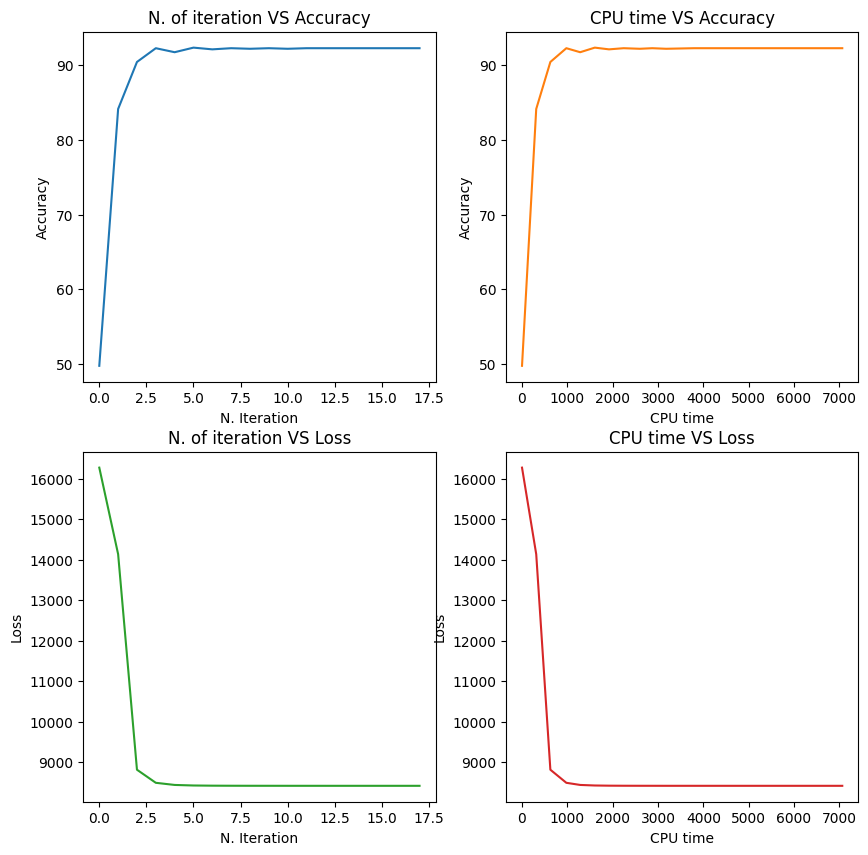

In [27]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_gsArmijo, vec_accuracy_gsArmijo, 'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_gsArmijo, vec_accuracy_gsArmijo, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_gsArmijo, vec_loss_gsArmijo, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_gsArmijo , vec_loss_gsArmijo, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

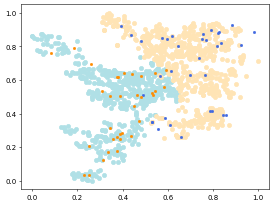

In [28]:
y_GS_Armijo = [1 if i >= 0 else -1 for i in y_GS_Armijo]

x1_GS = x_unlabeled[y_GS_Armijo==np.ones(n_unlabeled)]
y1_GS = y_unlabeled[y_GS_Armijo==np.ones(n_unlabeled)]
x2_GS = x_unlabeled[y_GS_Armijo==-np.ones(n_unlabeled)]
y2_GS = y_unlabeled[y_GS_Armijo==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS,y1_GS,c='powderblue')
plt.scatter(x2_GS,y2_GS,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gradient descent with exact line search

In [29]:
%%time
def exact_line_search(y, d):
       
    num_lu = 0  # double sommatory labeled/unlabeled at the nominator
    num_uu = 0  # double sommatory unlabeled/unlabeled at the nominator
    den_lu = 0  # double sommatory labeled/unlabeled at the denominator
    den_uu = 0  # double sommatory unlabeled/unlabeled at the denominator
            
    num_lu = np.sum(np.dot(w_lu, np.multiply(d, y))) - np.sum((np.dot(np.dot(w_lu, d), labels)))
    den_lu = np.sum(np.dot(w_lu, d.T**2))
    num_uu = np.sum(np.dot(w_uu, np.multiply(y, d))) - np.sum(np.dot(np.dot(w_uu, y), d))
    den_uu = np.sum(np.dot(w_uu, d**2)) - np.sum(np.dot(np.dot(w_uu, d), d))
    alpha = - (num_lu + num_uu)/(den_uu + den_lu)

    # the factor 2 goes away
    
    return alpha

def gradient_descent_ELS(y_0):
    
    start = time.time()
    y = y_0.copy()  # starting point
    tol = 1e-3
    normgrad = 1
    norm_incr = 1
    numiter = 0 #numero di iterazioni
  
    maxiter = 25000 # maximum number of iterations
    old_loss = vector_loss(y)

    init_time = time.time() * 1000

    vec_accuracy_ELS = [accuracy(y)]
    vec_iter_ELS = [0]
    vec_loss_ELS = [old_loss]
    ticks_ELS = [time.time() * 1000 - init_time]

    print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_ELS[0], vec_accuracy_ELS[0]))

    while numiter < maxiter and norm_incr > tol:

        numiter += 1

        d = - vector_gradient(y)
        normgrad = np.linalg.norm(d, 2)
        alpha = exact_line_search(y, d)
        y = y + alpha * d.T

        loss = vector_loss(y)
        acc = accuracy(y)

        norm_incr = abs(loss - old_loss)
        old_loss = loss

        vec_accuracy_ELS.append(acc)
        vec_iter_ELS.append(numiter)
        vec_loss_ELS.append(loss)

        if numiter == 0:
            print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, 0, loss, acc))
        else:
            print("Iterazione {} with alpha = {} -- Loss = {} -- Accuracy = {}%".format(numiter, alpha, loss, acc))
    

        ticks_ELS.append(time.time() * 1000 - init_time)
    end = time.time()
    print(y)
    print("Time = {}".format((end-start)))
    return y,vec_iter_ELS ,vec_accuracy_ELS ,vec_loss_ELS ,ticks_ELS



CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [30]:
%%time
### WE CALLTHE FUNCTION GRADIENT DESCEND WITH EXACT LINE SEARCH ###
y_GS_ELS, vec_iter_ELS, vec_accuracy_ELS, vec_loss_ELS, ticks_ELS = gradient_descent_ELS(y_0)


Initial loss = 16270.105389802755 -- Initial accuracy = 49.769938650306756
Iterazione 1 with alpha = 0.03411296124189295 -- Loss = 9329.49531510927 -- Accuracy = 80.06134969325154%
Iterazione 2 with alpha = 0.03447550079835362 -- Loss = 8640.821738778579 -- Accuracy = 90.49079754601227%
Iterazione 3 with alpha = 0.03339495337984198 -- Loss = 8489.182990161637 -- Accuracy = 92.10122699386504%
Iterazione 4 with alpha = 0.03344970143748561 -- Loss = 8443.979681890449 -- Accuracy = 91.87116564417178%
Iterazione 5 with alpha = 0.03325968952306963 -- Loss = 8427.815403904258 -- Accuracy = 92.25460122699387%
Iterazione 6 with alpha = 0.03308291376136391 -- Loss = 8421.386179012348 -- Accuracy = 92.17791411042946%
Iterazione 7 with alpha = 0.0336089915597834 -- Loss = 8418.58531031113 -- Accuracy = 92.25460122699387%
Iterazione 8 with alpha = 0.0326370493654771 -- Loss = 8417.29832319205 -- Accuracy = 92.17791411042946%
Iterazione 9 with alpha = 0.03382704181954304 -- Loss = 8416.657383478414 

CPU times: user 66.7 ms, sys: 2.38 ms, total: 69.1 ms
Wall time: 68.5 ms


Text(0, 0.5, 'Loss')

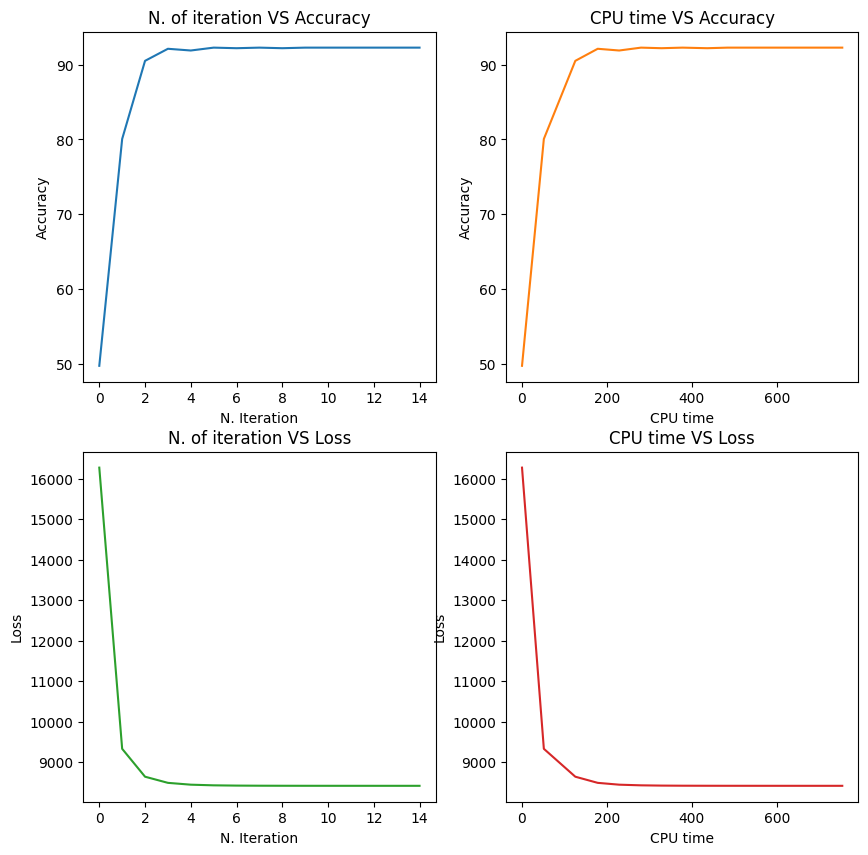

In [31]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_ELS, vec_accuracy_ELS, 'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_ELS, vec_accuracy_ELS, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_ELS, vec_loss_ELS, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_ELS, vec_loss_ELS, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

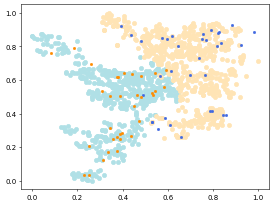

In [32]:
y_GS_ELS = [1 if i >= 0 else -1 for i in y_GS_ELS]

x1_GD_ELS = x_unlabeled[y_GS_ELS==np.ones(n_unlabeled)]
y1_GD_ELS = y_unlabeled[y_GS_ELS==np.ones(n_unlabeled)]
x2_GD_ELS = x_unlabeled[y_GS_ELS==-np.ones(n_unlabeled)]
y2_GD_ELS = y_unlabeled[y_GS_ELS==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GD_ELS,y1_GD_ELS,c='powderblue')
plt.scatter(x2_GD_ELS,y2_GD_ELS,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

## BCGD

In [33]:
column_sum = np.sum(w_uu, axis = 0) + np.sum(w_lu, axis = 0)
def step_gradient(grad, alpha, i):
    grad_1 = grad.copy()
    grad_1 += 2 * w_uu[i] * alpha
    grad_1[i] -= 2 * alpha * column_sum[i]
    return grad_1

In [34]:
def element_loss(x,i):
    term_1 = np.dot(w_lu[:,i], (x - labels)**2)
    term_2 = np.dot(w_uu[:,i], (x - unlabels)**2)
    return term_1 + 0.5 * term_2

### Gauss-Southwell BCGD (L)

In [35]:
def GS_BCGD_L(y_0):
  start = time.time()
  y = y_0.copy()
  tol = 1e-2

  init_time = time.time() * 1000

  numiter = 0
  maxiter = 25000
  
  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)

  vec_iter_GS_BCGD = [0]
  vec_accuracy_GS_BCGD = [accuracy(y)]
  vec_loss_GS_BCGD = [loss]
  ticks_GS_BCGD = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_GS_BCGD[0], vec_accuracy_GS_BCGD[0]))

  while normgrad > tol and numiter < maxiter:

    numiter += 1

    argmax = np.argmax(np.abs(grad))
    loss -= element_loss(y[argmax], argmax)
    alpha = (1/L) * grad[argmax]
    y[argmax] -= alpha
    grad = step_gradient(grad, alpha, argmax)
    loss += element_loss(y[argmax], argmax)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_GS_BCGD.append(numiter)
    vec_accuracy_GS_BCGD.append(acc)
    vec_loss_GS_BCGD.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))
    ticks_GS_BCGD.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_GS_BCGD, vec_accuracy_GS_BCGD, vec_loss_GS_BCGD, ticks_GS_BCGD
  

In [36]:
y_GS_BCGD_L, vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L, vec_loss_GS_BCGD_L, ticks_GS_BCGD_L = GS_BCGD_L(y_0)

Streaming output truncated to the last 5000 lines.
Iteration 20004 -- Loss: 7657.302181825695 -- Accuracy: 92.25460122699387
Iteration 20005 -- Loss: 7657.302404866414 -- Accuracy: 92.25460122699387
Iteration 20006 -- Loss: 7657.302202259901 -- Accuracy: 92.25460122699387
Iteration 20007 -- Loss: 7657.3019931367335 -- Accuracy: 92.25460122699387
Iteration 20008 -- Loss: 7657.30228801796 -- Accuracy: 92.25460122699387
Iteration 20009 -- Loss: 7657.301998232616 -- Accuracy: 92.25460122699387
Iteration 20010 -- Loss: 7657.301802866484 -- Accuracy: 92.25460122699387
Iteration 20011 -- Loss: 7657.3019152370125 -- Accuracy: 92.25460122699387
Iteration 20012 -- Loss: 7657.301643958895 -- Accuracy: 92.25460122699387
Iteration 20013 -- Loss: 7657.301526442765 -- Accuracy: 92.25460122699387
Iteration 20014 -- Loss: 7657.301814882844 -- Accuracy: 92.25460122699387
Iteration 20015 -- Loss: 7657.302030228552 -- Accuracy: 92.25460122699387
Iteration 20016 -- Loss: 7657.302221124974 -- Accuracy: 92.2

Text(0, 0.5, 'Loss')

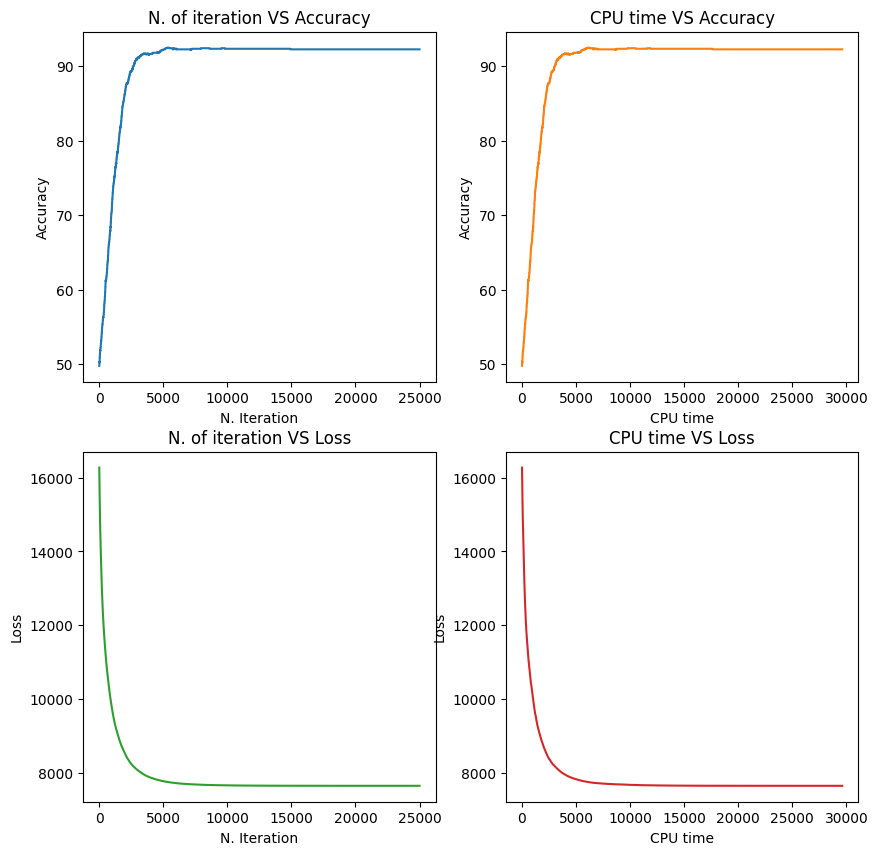

In [37]:
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_GS_BCGD_L, vec_accuracy_GS_BCGD_L, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_GS_BCGD_L, vec_loss_GS_BCGD_L, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_GS_BCGD_L, vec_loss_GS_BCGD_L, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

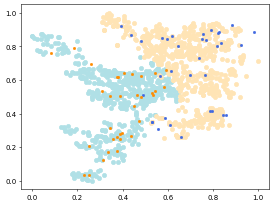

In [38]:
y_GS_BCGD_L = [1 if i >= 0 else -1 for i in y_GS_BCGD_L]

x1_GS_BCGD_L = x_unlabeled[y_GS_BCGD_L==np.ones(n_unlabeled)]
y1_GS_BCGD_L = y_unlabeled[y_GS_BCGD_L==np.ones(n_unlabeled)]
x2_GS_BCGD_L = x_unlabeled[y_GS_BCGD_L==-np.ones(n_unlabeled)]
y2_GS_BCGD_L = y_unlabeled[y_GS_BCGD_L==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS_BCGD_L, y1_GS_BCGD_L, c='powderblue')
plt.scatter(x2_GS_BCGD_L, y2_GS_BCGD_L, c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Gauss-Southwell BCGD (L_i)

In [39]:
def GS_BCGD_Li(y_0):
  start = time.time()
  y = y_0.copy()
  tol = 1e-2

  init_time = time.time() * 1000

  numiter = 0
  maxiter = 25000

  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  norm_incr = 1
  loss = vector_loss(y)
 
  vec_iter_GS_BCGD = [0]
  vec_accuracy_GS_BCGD = [accuracy(y)]
  vec_loss_GS_BCGD = [loss]
  ticks_GS_BCGD = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_GS_BCGD[0], vec_accuracy_GS_BCGD[0]))

  while normgrad > tol and numiter < maxiter:

    numiter += 1

    argmax = np.argmax(np.abs(grad))
    loss -= element_loss(y[argmax], argmax)
    alpha = (1/Li[argmax]) * grad[argmax]
    y[argmax] -= alpha
    grad = step_gradient(grad, alpha, argmax)
    loss += element_loss(y[argmax], argmax)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_GS_BCGD.append(numiter)
    vec_accuracy_GS_BCGD.append(acc)
    vec_loss_GS_BCGD.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))
    ticks_GS_BCGD.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_GS_BCGD, vec_accuracy_GS_BCGD, vec_loss_GS_BCGD, ticks_GS_BCGD

In [40]:
%%time
### CALL BCGD WITH GAUSS SOUTHWELL (L_i) ###
y_GS_BCGD_Li, vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, vec_loss_GS_BCGD_Li, ticks_GS_BCGD_Li = GS_BCGD_Li(y_0)

Streaming output truncated to the last 5000 lines.
Iteration 1508 -- Loss: 7758.551315503701 -- Accuracy: 92.25460122699387
Iteration 1509 -- Loss: 7758.225112336185 -- Accuracy: 92.25460122699387
Iteration 1510 -- Loss: 7757.826379378339 -- Accuracy: 92.25460122699387
Iteration 1511 -- Loss: 7757.2622054541325 -- Accuracy: 92.25460122699387
Iteration 1512 -- Loss: 7756.761236196546 -- Accuracy: 92.25460122699387
Iteration 1513 -- Loss: 7756.442727991408 -- Accuracy: 92.25460122699387
Iteration 1514 -- Loss: 7756.222900577396 -- Accuracy: 92.25460122699387
Iteration 1515 -- Loss: 7756.049000872639 -- Accuracy: 92.25460122699387
Iteration 1516 -- Loss: 7755.855765290053 -- Accuracy: 92.33128834355828
Iteration 1517 -- Loss: 7755.713970761481 -- Accuracy: 92.33128834355828
Iteration 1518 -- Loss: 7755.460294132743 -- Accuracy: 92.33128834355828
Iteration 1519 -- Loss: 7755.3542628933865 -- Accuracy: 92.33128834355828
Iteration 1520 -- Loss: 7755.006149682915 -- Accuracy: 92.3312883435582

CPU times: user 64.7 ms, sys: 8.35 ms, total: 73.1 ms
Wall time: 73 ms


Text(0, 0.5, 'Loss')

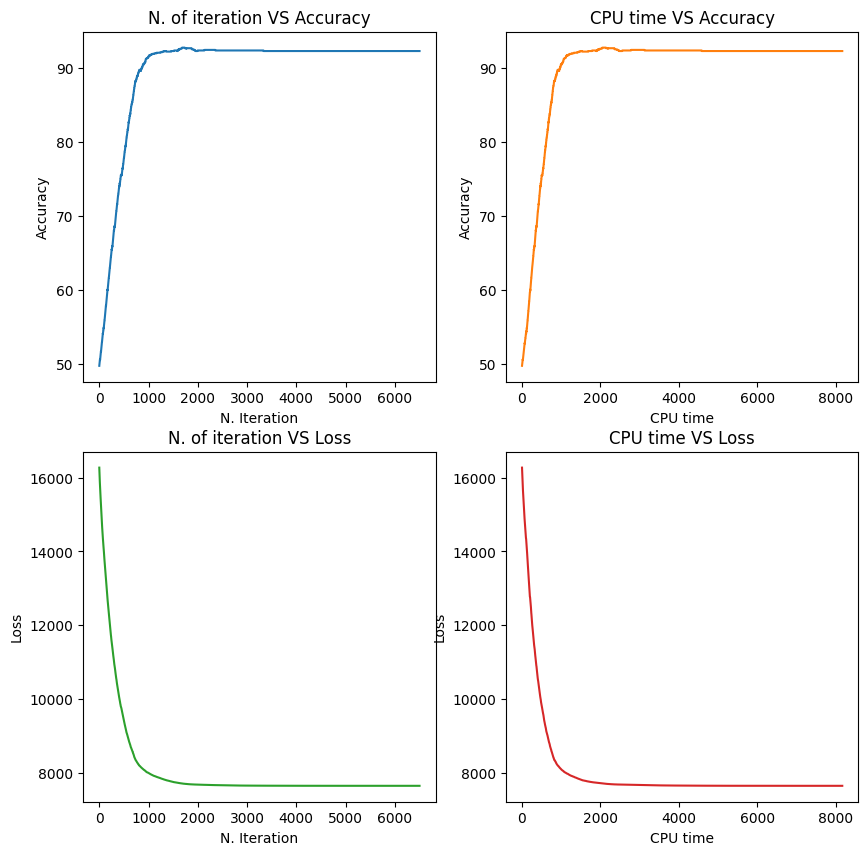

In [41]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_GS_BCGD_Li, vec_loss_GS_BCGD_Li, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_GS_BCGD_Li , vec_loss_GS_BCGD_Li, 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

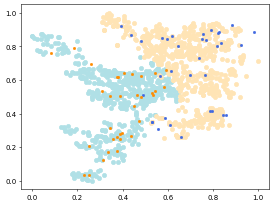

In [42]:
y_GS_BCGD_Li = [1 if i >= 0 else -1 for i in y_GS_BCGD_Li]

x1_GS_BCGD_Li = x_unlabeled[y_GS_BCGD_Li == np.ones(n_unlabeled)]
y1_GS_BCGD_Li = y_unlabeled[y_GS_BCGD_Li == np.ones(n_unlabeled)]
x2_GS_BCGD_Li = x_unlabeled[y_GS_BCGD_Li == -np.ones(n_unlabeled)]
y2_GS_BCGD_Li = y_unlabeled[y_GS_BCGD_Li == -np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_GS_BCGD_Li, y1_GS_BCGD_Li, c='powderblue')
plt.scatter(x2_GS_BCGD_Li, y2_GS_BCGD_Li, c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Random BCGD_Li (Nesterov)

In [43]:

def random_BCGDLi_Nesterov(y_0):
  y = y_0.copy()
  start = time.time()
  numiter = 0
  maxiter = 25000
  tol = 1e-2

  init_time = time.time() * 1000
 
  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)
  
  vec_iter_nesterov = [0]
  vec_accuracy_nesterov = [accuracy(y)]
  vec_loss_nesterov = [loss]
  ticks_nesterov = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_nesterov[0], vec_accuracy_nesterov[0]))


  while numiter < maxiter and normgrad > tol:
    
    numiter += 1

    i = np.random.choice(n_unlabeled, p = probs)
    loss -= element_loss(y[i], i)
    alpha = 1/Li[i] * grad[i]
    y[i] -= alpha
    grad = step_gradient(grad, alpha, i)
    loss += element_loss(y[i], i)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)
   
    vec_iter_nesterov.append(numiter)
    vec_accuracy_nesterov.append(acc)
    vec_loss_nesterov.append(loss)

    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))

    ticks_nesterov.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y, vec_iter_nesterov, vec_accuracy_nesterov, vec_loss_nesterov, ticks_nesterov

In [44]:
%%time
### WE CALL THE FUNCTION RANDOM BCGD WITH L_i (Nesterov) ###
y_nesterov, vec_iter_nesterov, vec_accuracy_nesterov, vec_loss_nesterov, ticks_nesterov  = random_BCGDLi_Nesterov(y_0)


Streaming output truncated to the last 5000 lines.
Iteration 20006 -- Loss: 7657.8400217264225 -- Accuracy: 92.25460122699387
Iteration 20007 -- Loss: 7657.8399740627365 -- Accuracy: 92.25460122699387
Iteration 20008 -- Loss: 7657.8399681842075 -- Accuracy: 92.25460122699387
Iteration 20009 -- Loss: 7657.839961479632 -- Accuracy: 92.25460122699387
Iteration 20010 -- Loss: 7657.839949201171 -- Accuracy: 92.25460122699387
Iteration 20011 -- Loss: 7657.839928718345 -- Accuracy: 92.25460122699387
Iteration 20012 -- Loss: 7657.839906397072 -- Accuracy: 92.25460122699387
Iteration 20013 -- Loss: 7657.839900123426 -- Accuracy: 92.25460122699387
Iteration 20014 -- Loss: 7657.839902099782 -- Accuracy: 92.25460122699387
Iteration 20015 -- Loss: 7657.839917824237 -- Accuracy: 92.25460122699387
Iteration 20016 -- Loss: 7657.839874998038 -- Accuracy: 92.25460122699387
Iteration 20017 -- Loss: 7657.839779555872 -- Accuracy: 92.25460122699387
Iteration 20018 -- Loss: 7657.839786587642 -- Accuracy: 92

CPU times: user 103 ms, sys: 872 µs, total: 104 ms
Wall time: 104 ms


Text(0, 0.5, 'Loss')

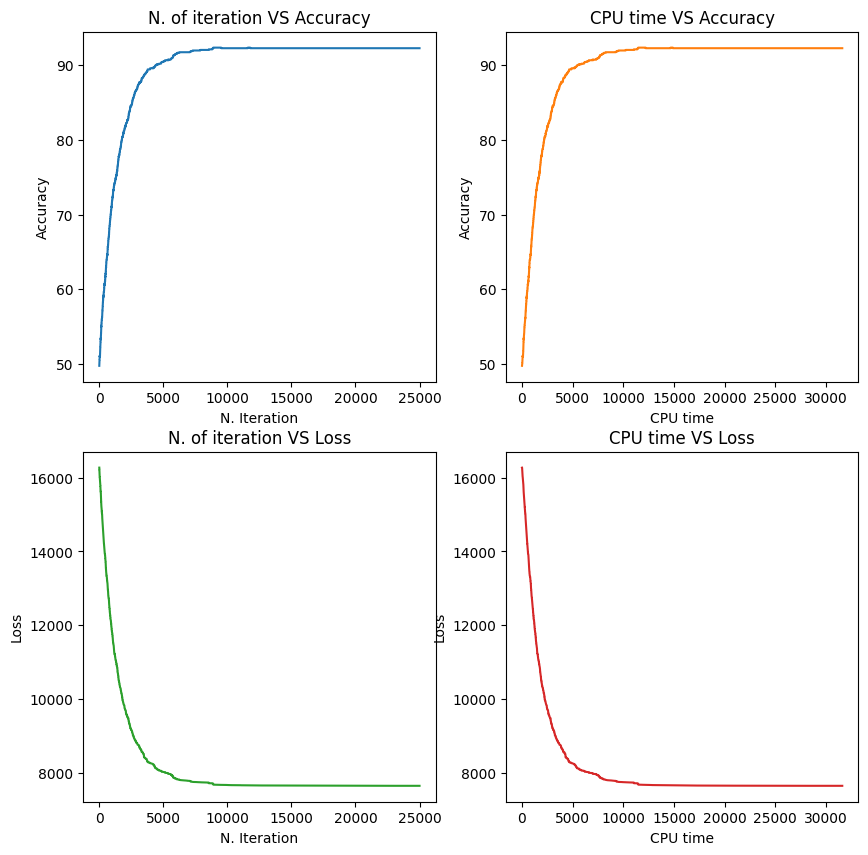

In [45]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_nesterov ,vec_accuracy_nesterov ,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_nesterov, vec_accuracy_nesterov , 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_nesterov , vec_loss_nesterov, 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_nesterov , vec_loss_nesterov , 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

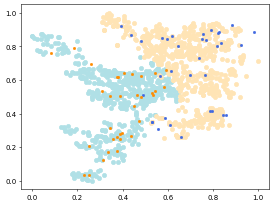

In [46]:
y_nesterov=[1 if i >= 0 else -1 for i in y_nesterov]

x1_nesterov=x_unlabeled[y_nesterov==np.ones(n_unlabeled)]
y1_nesterov=y_unlabeled[y_nesterov==np.ones(n_unlabeled)]
x2_nesterov=x_unlabeled[y_nesterov==-np.ones(n_unlabeled)]
y2_nesterov=y_unlabeled[y_nesterov==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_nesterov,y1_nesterov,c='powderblue')
plt.scatter(x2_nesterov,y2_nesterov,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

### Random BCGD_Li (Uniform)

In [47]:
def random_BCGDLi(y_0):
  y = y_0.copy()
  start = time.time()
  numiter = 0
  maxiter = 25000
  tol = 1e-2

  init_time = time.time() * 1000

  grad = vector_gradient(y)
  normgrad = np.linalg.norm(grad, 2)
  loss = vector_loss(y)
  norm_incr = 1

  vec_iter_Li_Uniform = [0]
  vec_accuracy_Li_Uniform = [accuracy(y)]
  vec_loss_Li_Uniform = [loss]
  ticks_Li_Uniform = [time.time() * 1000 - init_time]

  print("Initial loss = {} -- Initial accuracy = {}".format(vec_loss_Li_Uniform[0], vec_accuracy_Li_Uniform[0]))


  while numiter < maxiter and normgrad > tol:

    numiter += 1

    i = np.random.randint(0, n_unlabeled-1)
    loss -= element_loss(y[i], i)
    alpha = (1/Li[i]) * grad[i]
    y[i] -= alpha
    grad = step_gradient(grad, alpha, i)
    loss += element_loss(y[i], i)
    acc = accuracy(y)
    normgrad = np.linalg.norm(grad, 2)

    vec_iter_Li_Uniform.append(numiter)
    vec_accuracy_Li_Uniform.append(acc)
    vec_loss_Li_Uniform.append(loss)
    
    print("Iteration {} -- Loss: {} -- Accuracy: {}".format(numiter, loss, acc))

    ticks_Li_Uniform.append(time.time() * 1000 - init_time)

  end = time.time()
  print("Time = {}".format((end-start)))
  print(y)
  return y,vec_iter_Li_Uniform,vec_accuracy_Li_Uniform,vec_loss_Li_Uniform,ticks_Li_Uniform

In [48]:
%%time
### WE CALL THE FUNCTION RANDOM BCGD_Li (Uniform) ###
y_Li_Uniform, vec_iter_Li_Uniform, vec_accuracy_Li_Uniform, vec_loss_Li_Uniform, ticks_Li_Uniform = random_BCGDLi(y_0)


Streaming output truncated to the last 5000 lines.
Iteration 20006 -- Loss: 7663.825131856345 -- Accuracy: 92.17791411042946
Iteration 20007 -- Loss: 7663.825129588466 -- Accuracy: 92.17791411042946
Iteration 20008 -- Loss: 7663.825129142525 -- Accuracy: 92.17791411042946
Iteration 20009 -- Loss: 7663.825127370772 -- Accuracy: 92.17791411042946
Iteration 20010 -- Loss: 7663.825127482719 -- Accuracy: 92.17791411042946
Iteration 20011 -- Loss: 7663.825127202074 -- Accuracy: 92.17791411042946
Iteration 20012 -- Loss: 7663.8251258902455 -- Accuracy: 92.17791411042946
Iteration 20013 -- Loss: 7663.825123238081 -- Accuracy: 92.17791411042946
Iteration 20014 -- Loss: 7663.8251204298995 -- Accuracy: 92.17791411042946
Iteration 20015 -- Loss: 7663.825060304676 -- Accuracy: 92.17791411042946
Iteration 20016 -- Loss: 7663.825088086523 -- Accuracy: 92.17791411042946
Iteration 20017 -- Loss: 7663.8250881699805 -- Accuracy: 92.17791411042946
Iteration 20018 -- Loss: 7663.825089266755 -- Accuracy: 92

CPU times: user 80.8 ms, sys: 4.24 ms, total: 85 ms
Wall time: 83 ms


Text(0, 0.5, 'Loss')

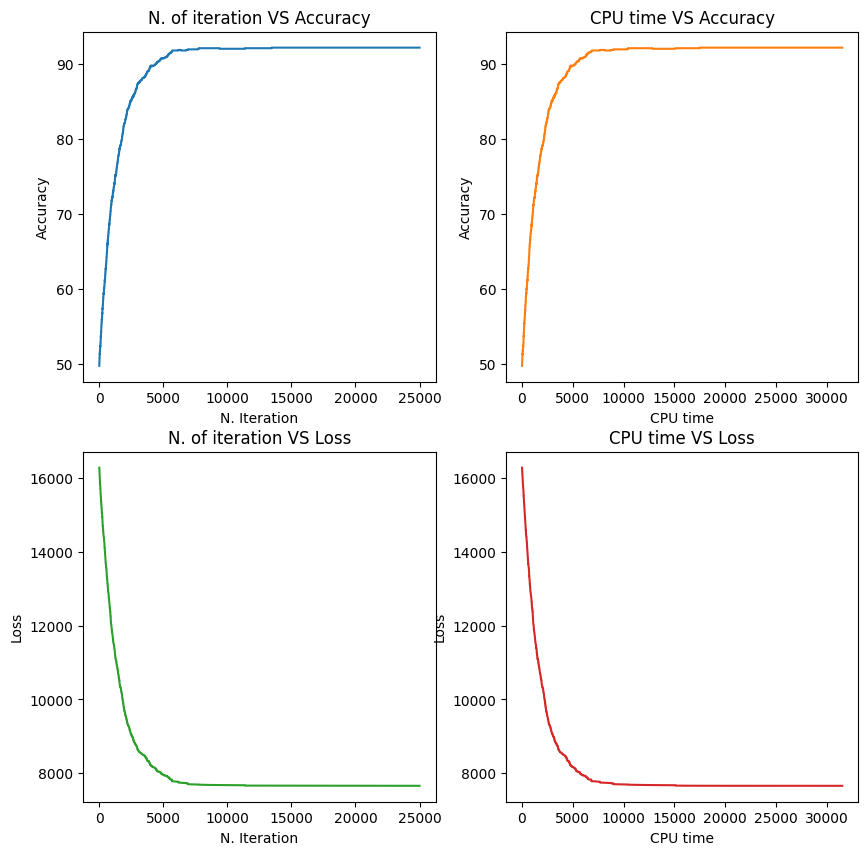

In [49]:
%%time
### WE PLOT THE RESULTS ###
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(vec_iter_Li_Uniform ,vec_accuracy_Li_Uniform ,'tab:blue')
axs[0, 0].set_title('N. of iteration VS Accuracy')
axs[0, 0].set_xlabel('N. Iteration')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(ticks_Li_Uniform , vec_accuracy_Li_Uniform, 'tab:orange')
axs[0, 1].set_title('CPU time VS Accuracy')
axs[0, 1].set_xlabel('CPU time')
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].plot(vec_iter_Li_Uniform, vec_loss_Li_Uniform , 'tab:green')
axs[1, 0].set_title('N. of iteration VS Loss')
axs[1, 0].set_xlabel('N. Iteration')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(ticks_Li_Uniform, vec_loss_Li_Uniform , 'tab:red')
axs[1, 1].set_title('CPU time VS Loss')
axs[1, 1].set_xlabel('CPU time')
axs[1, 1].set_ylabel('Loss')

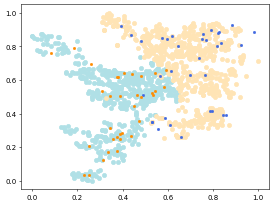

In [50]:
y_Li_Uniform=[1 if i >= 0 else -1 for i in y_Li_Uniform]

x1_Li_Uniform=x_unlabeled[y_Li_Uniform==np.ones(n_unlabeled)]
y1_Li_Uniform=y_unlabeled[y_Li_Uniform==np.ones(n_unlabeled)]
x2_Li_Uniform=x_unlabeled[y_Li_Uniform==-np.ones(n_unlabeled)]
y2_Li_Uniform=y_unlabeled[y_Li_Uniform==-np.ones(n_unlabeled)]
plt.figure(dpi=50)
plt.scatter(x1_Li_Uniform,y1_Li_Uniform,c='powderblue')
plt.scatter(x2_Li_Uniform,y2_Li_Uniform,c='moccasin')
plt.scatter(x1_l, y1_l, s=10, c='royalblue')
plt.scatter(x2_l, y2_l, s=10, c='darkorange')

## Plot comparison

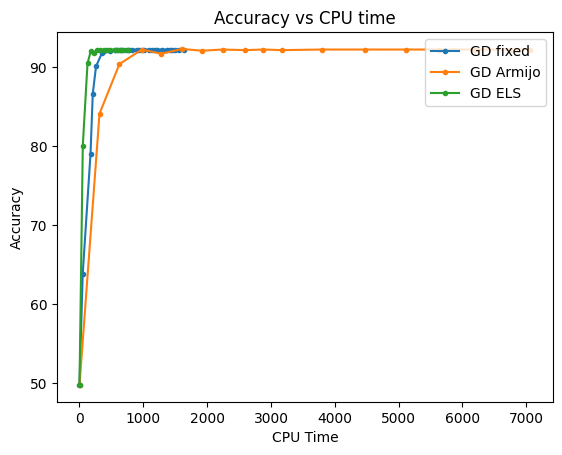

In [51]:
### PLOT CONFRONTATION ON ACCURACY VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_gd,vec_accuracy_gd,marker='.')
plt.plot(ticks_gsArmijo,vec_accuracy_gsArmijo,marker='.')
plt.plot(ticks_ELS,vec_accuracy_ELS,marker='.')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Accuracy")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'
    ],
    loc="upper right"
)

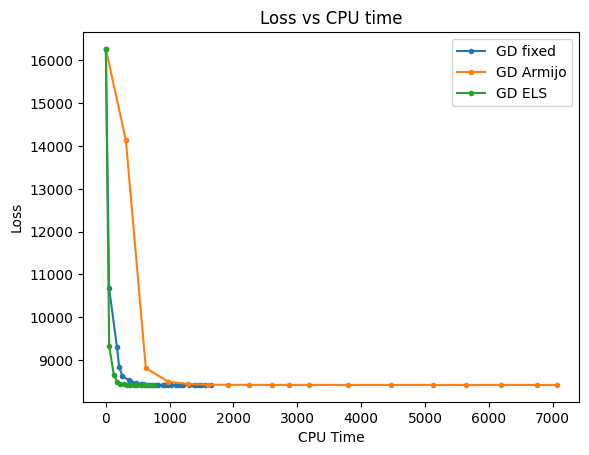

In [52]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_gd, vec_loss_gd, marker='.')
plt.plot(ticks_gsArmijo, vec_loss_gsArmijo, marker='.')
plt.plot(ticks_ELS, vec_loss_ELS, marker='.')

plt.title("Loss vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Loss")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'],
    loc="upper right"
)

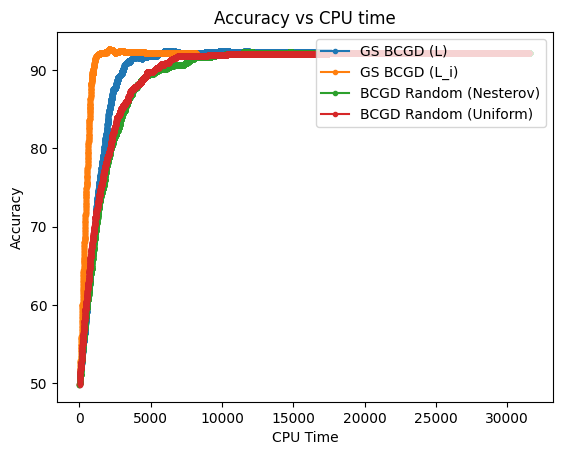

In [53]:
### PLOT CONFRONTATION ON ACCURACY VS CPU TIME ###
plt.figure(dpi=100)

plt.plot(ticks_GS_BCGD_L, vec_accuracy_GS_BCGD_L, marker = '.')
plt.plot(ticks_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, marker = '.')
plt.plot(ticks_nesterov, vec_accuracy_nesterov, marker = '.')
plt.plot(ticks_Li_Uniform,vec_accuracy_Li_Uniform,marker = '.')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Accuracy")
plt.legend(
    [ 
    'GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'],
    loc="upper right"
)


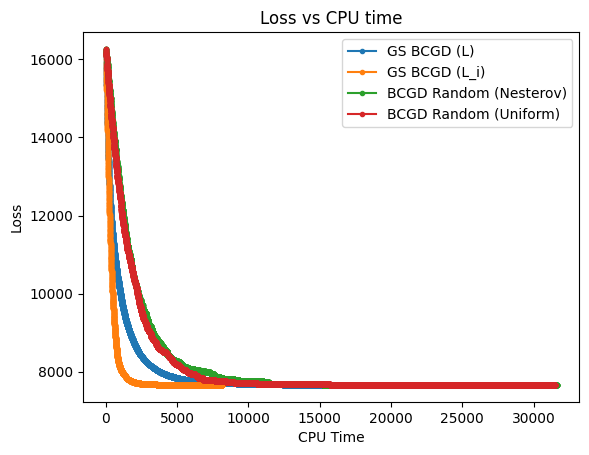

In [54]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(ticks_GS_BCGD_L, vec_loss_GS_BCGD_L, marker = '.')
plt.plot(ticks_GS_BCGD_Li, vec_loss_GS_BCGD_Li, marker = '.')
plt.plot(ticks_nesterov, vec_loss_nesterov, marker='.')
plt.plot(ticks_Li_Uniform, vec_loss_Li_Uniform, marker='.')
plt.title("Loss vs CPU time")
plt.xlabel("CPU Time")
plt.ylabel("Loss")
plt.legend(
    ['GS BCGD (L)',
    'GS BCGD (L_i)',
        'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'
 ],
    loc="upper right"
)

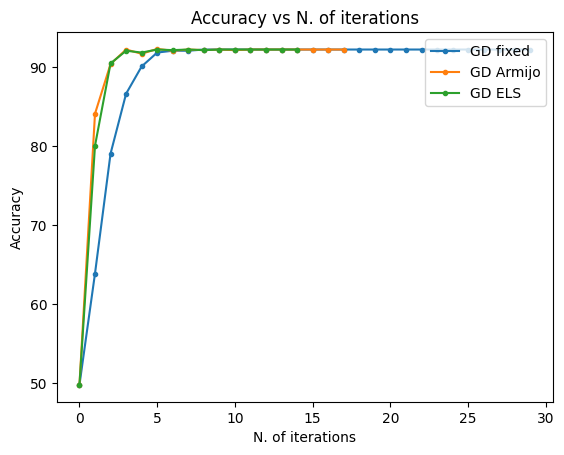

In [55]:
### PLOT CONFRONTATION ON ACCURACY VS ITERATIONS ###
plt.figure(dpi=100)
plt.plot(vec_iter_gd, vec_accuracy_gd, marker='.')
plt.plot(vec_iter_gsArmijo,vec_accuracy_gsArmijo,marker='.')
plt.plot(vec_iter_ELS, vec_accuracy_ELS,marker='.')
plt.title("Accuracy vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Accuracy")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'
    ],
    loc="upper right"
)

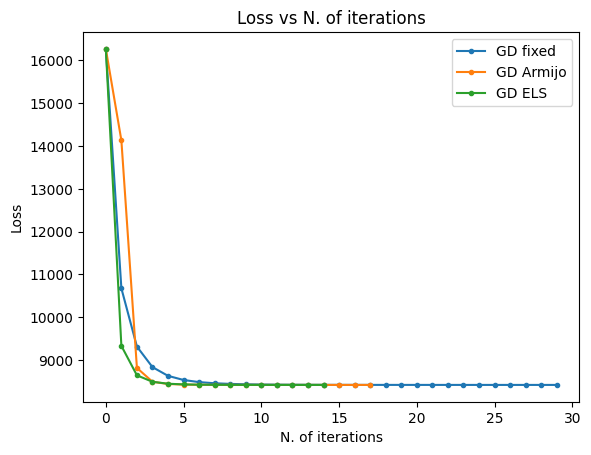

In [56]:
### PLOT CONFRONTATION ON LOSS VS ITERATIONS ###
plt.figure(dpi=100)
plt.plot(vec_iter_gd, vec_loss_gd, marker='.')
plt.plot(vec_iter_gsArmijo, vec_loss_gsArmijo, marker='.')
plt.plot(vec_iter_ELS, vec_loss_ELS, marker='.')

plt.title("Loss vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Loss")
plt.legend(
    ['GD fixed',
    'GD Armijo',
    'GD ELS'],
    loc="upper right"
)

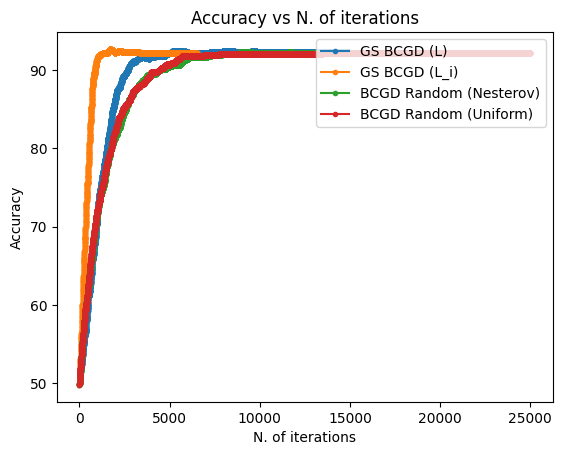

In [57]:
### PLOT CONFRONTATION ON ACCURACY VS N OF ITERATIONS ###
plt.figure(dpi=100)

plt.plot(vec_iter_GS_BCGD_L, vec_accuracy_GS_BCGD_L, marker = '.')
plt.plot(vec_iter_GS_BCGD_Li, vec_accuracy_GS_BCGD_Li, marker = '.')
plt.plot(vec_iter_nesterov, vec_accuracy_nesterov, marker = '.')
plt.plot(vec_iter_Li_Uniform,vec_accuracy_Li_Uniform,marker = '.')
plt.title("Accuracy vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Accuracy")
plt.legend(
    [ 
    'GS BCGD (L)',
    'GS BCGD (L_i)',
    'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'],
    loc="upper right"
)


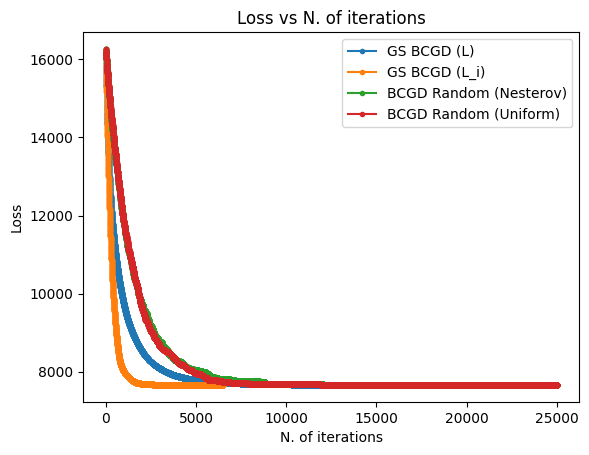

In [59]:
### PLOT CONFRONTATION ON LOSS VS CPU TIME ###
plt.figure(dpi=100)
plt.plot(vec_iter_GS_BCGD_L, vec_loss_GS_BCGD_L, marker = '.')
plt.plot(vec_iter_GS_BCGD_Li, vec_loss_GS_BCGD_Li, marker = '.')
plt.plot(vec_iter_nesterov, vec_loss_nesterov, marker='.')
plt.plot(vec_iter_Li_Uniform, vec_loss_Li_Uniform, marker='.')
plt.title("Loss vs N. of iterations")
plt.xlabel("N. of iterations")
plt.ylabel("Loss")
plt.legend(
    ['GS BCGD (L)',
    'GS BCGD (L_i)',
     'BCGD Random (Nesterov)',
    'BCGD Random (Uniform)'],
    loc="upper right"
)